In [8]:
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import math as m
import numpy as np
import seaborn as sns
import statsmodels as sm
import statsmodels.api as sma
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
sns.set()

In [32]:
def growth_rate_to_doubling_time(growth_rates):
    return np.sign(growth_rates) * (np.log(2) / (np.sign(growth_rates) * growth_rates))

def doubling_time_to_growth_rate(doubling_times):
    return np.sign(doubling_times) * ( np.log(2) / (np.sign(doubling_times) * doubling_times))

In [10]:
data = pd.read_excel("../../Data/Simulation Results/UK Model/back_tracing_pars_fixed_high_app.xlsx", index_col = 0)
days_simulated = 25

In [11]:
data

,hazard_rate_scale,infection_reporting_prob,contact_tracing_success_prob,contact_trace_delay_par,global_contact_reduction,prob_has_trace_app,test_before_propagate_tracing,test_delay_mean,probable_infections_need_test,number_of_days_to_trace_backwards,...,15,16,17,18,19,20,21,22,23,24
0,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,6,...,1167,1341,1539,1764,2004,2286,2598,2949,3346,3799
1,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,13,...,1194,1390,1576,1802,2048,2324,2638,2959,3308,3702
2,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,11,...,1359,1571,1778,2017,2278,2555,2870,3219,3589,3991
3,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,4,...,1201,1403,1643,1896,2206,2534,2932,3366,3853,4416
4,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,5,...,1310,1527,1747,2005,2279,2600,2980,3386,3829,4328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,14,...,1371,1577,1821,2078,2386,2671,3018,3422,3860,4308
996,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,3,...,1186,1366,1600,1851,2125,2450,2817,3256,3730,4318
997,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,10,...,1266,1503,1712,1981,2264,2585,2956,3376,3813,4290
998,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,9,...,1171,1358,1546,1719,1953,2239,2533,2853,3206,3638


In [12]:
infection_counts = [str(i) for i in range(days_simulated)]
infection_counts = data[infection_counts]

Text(0.5, 1.0, 'Total Infected')

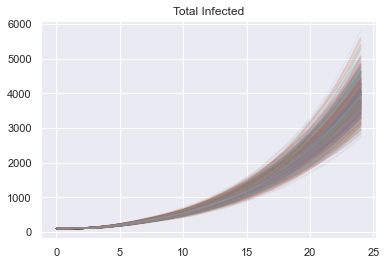

In [13]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_], alpha = 0.1)
plt.title("Total Infected")

Text(0.5, 1.0, '$log_2$(Total Infected)')

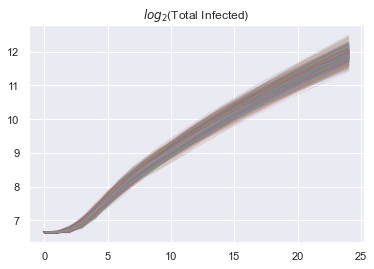

In [14]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].apply(lambda x: np.log2(x)), alpha = 0.1)
plt.title("$log_2$(Total Infected)")

Text(0.5, 1.0, 'Infection Incidence')

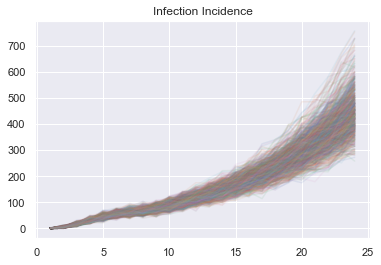

In [15]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.1)
plt.title("Infection Incidence")

Text(0.5, 1.0, 'Infection Incidence (10 epidemics)')

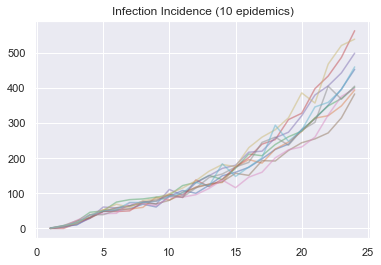

In [16]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.5)
plt.title("Infection Incidence (10 epidemics)")

Text(0.5, 1.0, '$Log_e$(Case Incidence) (14 epidemics)')

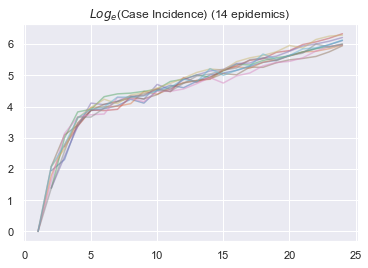

In [17]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x)), alpha = 0.5)
plt.title("$Log_e$(Case Incidence) (14 epidemics)")
#plt.savefig("Figures/Log_case_incidence.png")

We can see the variance begins to increase for the exponentially decaying epidemcis as they near 0. In order to get good estimation for the epidemics, we icnrease the starting number of infections. In this experiment, we start with 5000 infected, let the process run for 10 days, and then estimated the growth rate using days 10-30.

In [18]:
log_diff = infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x))

data_set_up = {
    "log_case_incidence": log_diff[10:days_simulated],
    "time": list(range(10, days_simulated))
}
dataframe = pd.DataFrame(data_set_up)

OLS Regression Results                            
Dep. Variable:     log_case_incidence   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     309.7
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           1.90e-10
Time:                        15:27:27   Log-Likelihood:                 13.280
No. Observations:                  15   AIC:                            -22.56
Df Residuals:                      13   BIC:                            -21.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4260      0.112     30.477      0.000       3.183       3.669
t

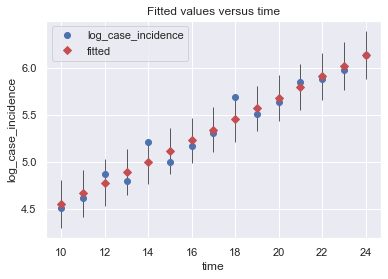

In [19]:
y, X = dmatrices('log_case_incidence ~ time', 
                 data = dataframe)
model = sma.OLS(y, X)
res = model.fit()
print(res.summary())
fig = sm.graphics.regressionplots.plot_fit(res, 1)
print(f"doublign time = {m.log(2)/res.params[1]}")

In [20]:
data_subset = infection_counts

In [21]:
growth_rates = []
for _ in range(data_subset.shape[0]):
    print(f"current fit; {_}", end = "\r")
    
    log_diff = data_subset.iloc[_].diff(1).apply(lambda x: np.log(x))

    data_set_up = {
        "log_case_incidence": log_diff[10:25],
        "time": list(range(10, 25))
    }
    dataframe = pd.DataFrame(data_set_up)
    dataframe = pd.DataFrame(data_set_up)
    
    y, X = dmatrices('log_case_incidence ~ time', 
                     data = dataframe)
    model = sma.RLM(y, X)
    res = model.fit()
    growth_rates.append(res.params[1])

    if res.params[1] == -float("inf"):
        print(f"missing data in line {_}")

current fit; 999

In [22]:
x = pd.Series(growth_rates) # 200 values
#x = x[x.between(x.quantile(.05), x.quantile(.95))] # without outliers

Text(0.5, 1.0, 'Distribution of Growth Rates')

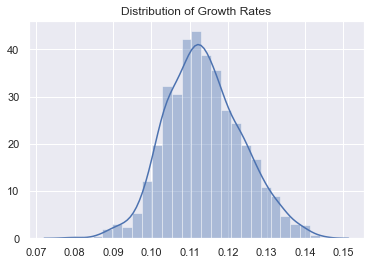

In [23]:
sns.distplot(x)
plt.title("Distribution of Growth Rates")

In [24]:
data_pars = data[data.columns[0:11]]
growth_rate_series = pd.Series(growth_rates)
data_pars["growth_rate"] = growth_rate_series

In [25]:
data_pars

,hazard_rate_scale,infection_reporting_prob,contact_tracing_success_prob,contact_trace_delay_par,global_contact_reduction,prob_has_trace_app,test_before_propagate_tracing,test_delay_mean,probable_infections_need_test,number_of_days_to_trace_backwards,backwards_tracing_time_limit,growth_rate
0,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,6,28,0.113314
1,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,13,22,0.108700
2,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,11,34,0.095784
3,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,4,31,0.131323
4,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,5,31,0.110830
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,14,24,0.103365
996,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,3,14,0.136570
997,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,10,19,0.117957
998,0.229609,0.3,0.8,2,0.3,0.6,True,1.52,False,9,12,0.107858


In [26]:
y, X = dmatrices('growth_rate ~ number_of_days_to_trace_backwards + number_of_days_to_trace_backwards**2', 
                 data = data_pars)
model_2 = sma.OLS(y, X)
res = model_2.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:            growth_rate   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     534.3
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           5.20e-95
Time:                        15:27:39   Log-Likelihood:                 3411.9
No. Observations:                1000   AIC:                            -6820.
Df Residuals:                     998   BIC:                            -6810.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                         

In [27]:
y, X = dmatrices('growth_rate ~  number_of_days_to_trace_backwards + I(number_of_days_to_trace_backwards**2)', 
                 data = data_pars)
model_2 = sma.OLS(y, X)
res = model_2.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:            growth_rate   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     442.9
Date:                Sat, 20 Jun 2020   Prob (F-statistic):          2.35e-138
Time:                        15:27:39   Log-Likelihood:                 3515.4
No. Observations:                1000   AIC:                            -7025.
Df Residuals:                     997   BIC:                            -7010.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept         

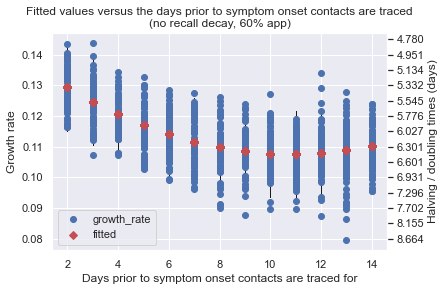

In [38]:
fig, ax = plt.subplots()

sm.graphics.regressionplots.plot_fit(res, "number_of_days_to_trace_backwards", ax = ax)

y_vals = np.linspace(0.145, 0.08, 14)
ax2 = ax.secondary_yaxis("right", functions=(growth_rate_to_doubling_time, doubling_time_to_growth_rate))
ax2.set_ticks(growth_rate_to_doubling_time(y_vals), minor = False)

plt.title("Fitted values versus the days prior to symptom onset contacts are traced\n(no recall decay, 60% app)")
plt.xlabel("Days prior to symptom onset contacts are traced for")
plt.ylabel("Growth rate")

ax2.set_ylabel("Halving / doubling times (days)")
plt.savefig("../../Figures/UK Model/days_prior_to_symptom_onset_recall_high_app.png", bbox_inches = 'tight')
plt.savefig("../../Figures/UK Model/days_prior_to_symptom_onset_recall_high_app.svg", bbox_inches = 'tight')


## Residuals vs Fitted Value

There doesn't appear to be any systematic deviation from our predicted value

Text(0, 0.5, 'Residual')

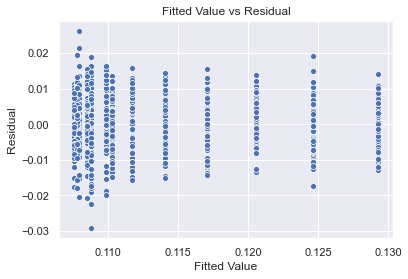

In [30]:
sns.scatterplot(res.fittedvalues, res.resid)
plt.title("Fitted Value vs Residual")
plt.xlabel("Fitted Value")
plt.ylabel("Residual")

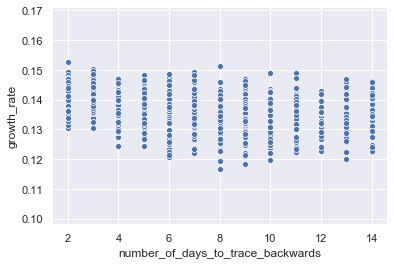

In [27]:
sns.scatterplot(data_pars["number_of_days_to_trace_backwards"], data_pars["growth_rate"])

## Residual Distribution

Text(0.5, 1.0, 'Distribution of the residuals')

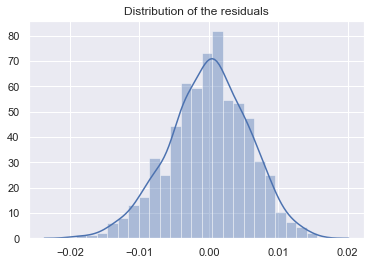

In [28]:
sns.distplot(res.resid)
plt.title("Distribution of the residuals")

## Comparison to reference distributions

In [248]:
reference_coefs = pd.read_excel("../../Data/Reference/OLS_coefficients.xlsx", index_col = 0)
reference_coefs

,intercept,coef_contact_reduction,coef_contact_reduction**2,coef_contact_reduction**2.1
0,0.22251,-0.255676,0.123382,-0.286964


In [249]:
c = reference_coefs["intercept"].loc[0]
beta_0 = reference_coefs["coef_contact_reduction"].loc[0]
beta_1 = reference_coefs["coef_contact_reduction**2"].loc[0]
beta_2 = reference_coefs["coef_contact_reduction**2.1"].loc[0]
x = np.linspace(0, 0.9)
y = c + beta_0*x + beta_1*x**2 + beta_2*x**3

Text(0.5, 0, '% reduction in global contacts')

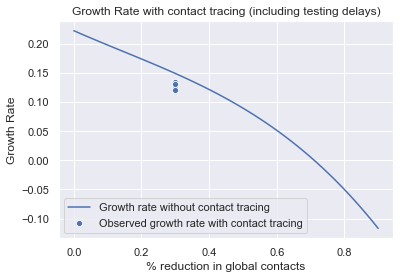

In [250]:
sns.scatterplot(data_pars["global_contact_reduction"], res.fittedvalues)
plt.plot(x, y)
plt.legend(("Growth rate without contact tracing", "Observed growth rate with contact tracing"))
plt.title("Growth Rate with contact tracing (including testing delays)")
plt.ylabel("Growth Rate")
plt.xlabel("% reduction in global contacts")

In [251]:
import numpy.random as npr

In [252]:
npr.poisson(2.5)

4

# Backwards Tracing Time Limit